# Visión por Computadora 2024 - Tercer Proyecto

- Esteban Aldana Guerra 20591
- Jose Mariano Reyes
- Juan Angel Carrera
- Luis Pedro Gonzales  

#### Importar Librerias Correspondientes

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
import cv2 as cv
from time import time

#### Configuración Inicial: Umbral de Coincidencias y Creación de SIFT

In [44]:
MIN_MATCH_COUNT = 3



sift = cv.SIFT_create()

#### Lectura y Redimensionamiento de Imágenes

In [45]:
path = 'imgs/uni2/'

img_ext = '.jpg'
imgnumber = 5
resize_factor = 1

# Leer las imágenes en color y escala de grises
im_color = []  # Para visualización y costura
im_gray = []   # Para procesamiento de homografías, etc.
for i in range(1, imgnumber + 1):
    full_name = path + str(i) + img_ext

    # Leer la imagen en color y redimensionarla
    img_color = cv.imread(full_name)
    img_color = cv.resize(img_color, (0, 0), fx=resize_factor, fy=resize_factor)

    # Leer la imagen en escala de grises y redimensionarla
    img_gray = cv.imread(full_name, cv.IMREAD_GRAYSCALE)
    img_gray = cv.resize(img_gray, (0, 0), fx=resize_factor, fy=resize_factor)

    # Añadir imágenes redimensionadas a las listas
    im_color.append(img_color)
    im_gray.append(img_gray)

#### Crear un Arreglo para las Dimensiones

In [46]:
shapes = np.zeros((imgnumber,2)).astype(int)

for i in range(imgnumber):
    shapes[i,:] = im_gray[i].shape[:2]

print(shapes)

[[1600  900]
 [1600  900]
 [1600  900]
 [1600  900]
 [1600  900]]


#### Detección de Puntos Clave y Cálculo de Descriptores con SIFT

In [47]:
kps =[] 
des = []

for i in range(imgnumber):
    kp, ds = sift.detectAndCompute(im_gray[i],None)
    kps.append(kp)
    des.append(ds)
    print('Image ' + str(i) + ' has ' + str(len(kp)) + ' keypoints')

Image 0 has 9338 keypoints
Image 1 has 10643 keypoints
Image 2 has 10522 keypoints
Image 3 has 11959 keypoints
Image 4 has 9719 keypoints


#### Emparejamiento de Descriptores con BFMatcher

In [48]:
bf = cv.BFMatcher()

matches = []
goods = []

for i in range(imgnumber-1):
    matches.append(bf.knnMatch(des[i],des[i+1],k=2))

    print("Total matches from image {} to image {} are {}".format(i,i+1,len(matches[i])))

    good = []

    for m,n in matches[i]:
        if m.distance < 0.75*n.distance:
            good.append(m)

    goods.append(good)
    print("Good matches from image {} to image {} are {}".format(i,i+1,len(good)))

Total matches from image 0 to image 1 are 9338
Good matches from image 0 to image 1 are 647
Total matches from image 1 to image 2 are 10643
Good matches from image 1 to image 2 are 408
Total matches from image 2 to image 3 are 10522
Good matches from image 2 to image 3 are 1007
Total matches from image 3 to image 4 are 11959
Good matches from image 3 to image 4 are 865


#### Visualización de Coincidencias y Verificación de Canales

Imagen 0: escala de grises.
Imagen 1: escala de grises.
Imagen 2: escala de grises.
Imagen 3: escala de grises.
Imagen 4: escala de grises.


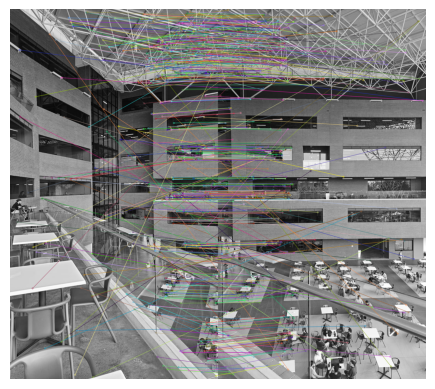

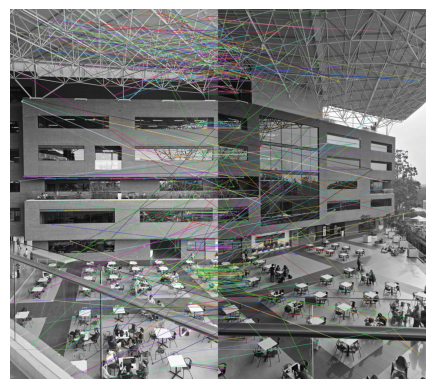

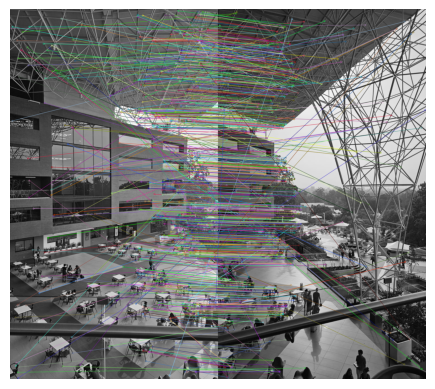

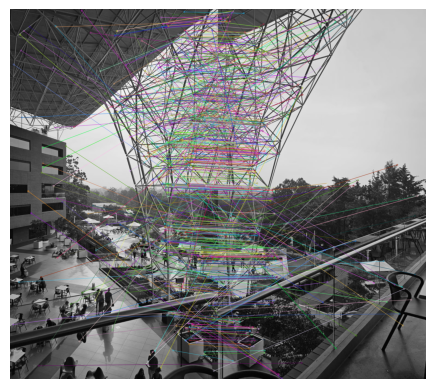

In [49]:
import matplotlib.pyplot as plt
import cv2 as cv

# Verificar que las imágenes originales sean en color y que tengan 3 canales
for i, img in enumerate(im_gray):
    if len(img.shape) == 2:
        print(f"Imagen {i}: escala de grises.")
    elif img.shape[2] == 3:
        print(f"Imagen {i}: color (3 canales).")

# Procesamiento de coincidencias
# Dibuja coincidencias entre imágenes y muestra en color
# Dibuja coincidencias entre imágenes y muestra en color
for i in range(1, imgnumber):
    if len(goods[i - 1]) > 0:
        # Dibuja las coincidencias utilizando imágenes en color, pero basándose en puntos clave en escala de grises
        draw = cv.drawMatches(im_gray[i - 1], kps[i - 1], im_gray[i], kps[i], goods[i - 1], im_color[i - 1], flags=2)

        # Convierte de BGR a RGB para mostrarlo en matplotlib
        draw_rgb = cv.cvtColor(draw, cv.COLOR_BGR2RGB)

        # Mostrar usando matplotlib
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.show()
    else:
        print(f"No good matches between image {i} and {i - 1}.")

#### Encontrar la Homografía entre Dos Imágenes

In [50]:

def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match.queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match.trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv.findHomography(
        SecImage_pts, BaseImage_pts, cv.RANSAC, 4.0)

    return HomographyMatrix, Status


#### Cálculo y Almacenamiento de Matrices de Homografía

In [51]:
H = [np.eye(3)]  

for i in range(1, imgnumber):
    # Verificar si hay suficientes coincidencias
    if len(goods[i - 1]) >= MIN_MATCH_COUNT:
        # Encontrar la homografía entre las imágenes i e i-1

        H_i, status = FindHomography(goods[i - 1], kps[i - 1], kps[i])
        H.append(H_i)
        print(f"Homography matrix between image {i} and {i-1} is:\n{H_i}")

Homography matrix between image 1 and 0 is:
[[ 6.16726546e-01 -1.31056245e-02  5.79202290e+02]
 [-3.36401301e-01  9.29977825e-01  6.15875771e+01]
 [-4.20613989e-04  6.21096050e-06  1.00000000e+00]]
Homography matrix between image 2 and 1 is:
[[ 4.93323068e-01  3.28215590e-03  7.34826968e+02]
 [-4.03262819e-01  9.34094561e-01  4.75040506e+01]
 [-5.40180052e-04 -9.90979650e-06  1.00000000e+00]]
Homography matrix between image 3 and 2 is:
[[ 6.36049317e-01  4.09086912e-03  5.44209499e+02]
 [-3.31756946e-01  9.52597573e-01  3.41921051e+01]
 [-4.30045729e-04  2.26073868e-05  1.00000000e+00]]
Homography matrix between image 4 and 3 is:
[[ 5.52050762e-01 -2.75488568e-03  6.49574812e+02]
 [-3.88083505e-01  9.47742089e-01  3.50303931e+01]
 [-4.94547162e-04  1.11525868e-05  1.00000000e+00]]


#### Impresión de las Matrices de Homografía

In [52]:
for i in range(0,imgnumber):
    print(H[i])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 6.16726546e-01 -1.31056245e-02  5.79202290e+02]
 [-3.36401301e-01  9.29977825e-01  6.15875771e+01]
 [-4.20613989e-04  6.21096050e-06  1.00000000e+00]]
[[ 4.93323068e-01  3.28215590e-03  7.34826968e+02]
 [-4.03262819e-01  9.34094561e-01  4.75040506e+01]
 [-5.40180052e-04 -9.90979650e-06  1.00000000e+00]]
[[ 6.36049317e-01  4.09086912e-03  5.44209499e+02]
 [-3.31756946e-01  9.52597573e-01  3.41921051e+01]
 [-4.30045729e-04  2.26073868e-05  1.00000000e+00]]
[[ 5.52050762e-01 -2.75488568e-03  6.49574812e+02]
 [-3.88083505e-01  9.47742089e-01  3.50303931e+01]
 [-4.94547162e-04  1.11525868e-05  1.00000000e+00]]


In [53]:
# # change panorama tro based at central image
# center = imgnumber//2
# if (center > 0):
#     for i in range(imgnumber):
#         H[i] = np.linalg.inv(H[center]) @ H[i]
    
#     H[center] = np.eye(3)

In [54]:
# print('Homographies adjusted to central image')
# for i in range(imgnumber):
#     print(H[i])

#### Actualización de Homografías y Cálculo del Tamaño del Marco Final


In [55]:
import numpy as np
import cv2 as cv

def update_homography(H, new_H):
    """ Actualiza la matriz de homografía acumulada con una nueva transformación. """
    return np.dot(new_H, H)

def calculate_final_frame_size(homographies, image_shapes):
    """ Calcula el tamaño del marco final basado en todas las transformaciones y tamaños de imagen. """
    min_x, min_y = 0, 0
    max_x, max_y = 0, 0
    
    # Iniciar con la primera imagen, que está sin transformar.
    (h, w) = image_shapes[0]
    corners = np.float32([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
    
    # Evaluar los límites de las esquinas de la primera imagen.
    for i in range(len(homographies)):
        transformed_corners = np.dot(homographies[i], corners)
        transformed_corners /= transformed_corners[2]  # Normalizar
        
        x = transformed_corners[0, :]
        y = transformed_corners[1, :]
        
        min_x = min(min_x, min(x))
        max_x = max(max_x, max(x))
        min_y = min(min_y, min(y))
        max_y = max(max_y, max(y))
    
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height)

# Lista de matrices de homografía y tamaños de imagen
homographies = [np.eye(3)]  # Inicializar con la matriz identidad para la primera imagen

# Supongamos que tienes una lista `H` que contiene las homografías entre pares consecutivos de imágenes
for H_pair in H[1:]:
    homographies.append(update_homography(homographies[-1], H_pair))

# Supongamos que `shapes` contiene los tamaños (altura, anchura) de cada imagen
image_shapes = shapes

# Calcular el tamaño del marco final
final_frame_size = calculate_final_frame_size(homographies, image_shapes)
print("El tamaño del marco final es:", final_frame_size)


El tamaño del marco final es: (94625, 100898)


#### Creación de una Imagen Panorámica con Corrección y Blending

In [56]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def update_homography(H, new_H):
    """ Actualiza la matriz de homografía acumulada con una nueva transformación. """
    return np.dot(new_H, H)

def adjust_homographies_for_central_image(homographies, central_index):
    """ Ajusta las homografías para que todas las imágenes se alineen con la imagen central. """
    # Copiar las homografías originales para evitar modificar la lista original
    adjusted_homographies = homographies[:]
    inverse_central_H = np.linalg.inv(homographies[central_index])
    
    # Reajustar las homografías para cada imagen en relación con la imagen central
    for i in range(len(homographies)):
        adjusted_homographies[i] = np.dot(inverse_central_H, homographies[i])
    
    return adjusted_homographies

def calculate_final_frame_size(homographies, image_shapes):
    """ Calcula el tamaño del marco final basado en todas las transformaciones y tamaños de imagen. """
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    
    for i, H in enumerate(homographies):
        h, w = image_shapes[i]
        corners = np.array([
            [0, 0, 1],
            [w - 1, 0, 1],
            [w - 1, h - 1, 1],
            [0, h - 1, 1]
        ]).T
        transformed_corners = np.dot(H, corners)
        transformed_corners /= transformed_corners[2, :]  # Normalizar
        
        min_x = min(min_x, np.min(transformed_corners[0, :]))
        max_x = max(max_x, np.max(transformed_corners[0, :]))
        min_y = min(min_y, np.min(transformed_corners[1, :]))
        max_y = max(max_y, np.max(transformed_corners[1, :]))
    
    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    corrected_homographies = [np.dot(translation, H) for H in homographies]
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height), corrected_homographies

def stitch_images(images, homographies, frame_size):
    """ Junta las imagenes y realiza blending de fusion lineal """
    stitched_image = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.float32)
    weight_sum = np.zeros((frame_size[1], frame_size[0]), dtype=np.float32)
    
    for i, image in enumerate(images):
        if len(image.shape) == 2:
            image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        
        transformed_image = cv.warpPerspective(image, homographies[i], (frame_size[0], frame_size[1]))
        
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        cv.rectangle(mask, (10, 10), (mask.shape[1] - 10, mask.shape[0] - 10), 1, thickness = cv.FILLED)
        mask = cv.GaussianBlur(mask, (51, 51), 0)
        
        transformed_mask = cv.warpPerspective(mask, homographies[i], (frame_size[0], frame_size[1]))
        
        for c in range(3):
            stitched_image[..., c] += transformed_image[..., c] * transformed_mask
        
        weight_sum += transformed_mask
    
    stitched_image /= np.stack([weight_sum] * 3, axis = -1)
    
    return stitched_image.astype(np.uint8)

# Supongamos que im_color contiene las imágenes y homographies las transformaciones
central_index = 1  # Índice de la imagen que será el centro (ajustar según sea necesario)
adjusted_homographies = adjust_homographies_for_central_image(homographies, central_index)

image_shapes = [(img.shape[0], img.shape[1]) for img in im_color]
final_frame_size, corrected_homographies = calculate_final_frame_size(adjusted_homographies, image_shapes)
panoramic_image = stitch_images(im_color, corrected_homographies, final_frame_size)

plt.figure(figsize = (10, 5))
plt.imshow(cv.cvtColor(panoramic_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

MemoryError: Unable to allocate 4.97 TiB for an array with shape (546196, 833042, 3) and data type float32